# Next Best Action Experiment Analysis (Template)

Over the course of the next few weeks the Data Platforms team will be conducting a series of experiments (split-tests) to assess to efficacy of the Next Best Action (NBA) model; in-line with their allocated testing phase. These documents provide a breakdown of the results from these experiments.

The experiment is a A/B/n design and there are three variants (inc control):

    A. Control group: 25% will NOT see the newsletter pop up at all and no NBA (No change implemented/like the pop-up has never been implemented)

    B. Control group: 25% - Newsletter popup implemented and NBA not implemented

    C. New Test of NBA: 50% will see the newsletter popup based on NBA decision - newsletter popup implemented AND NBA implemented

The two primary metrics for this analysis will be:

    1. Page views per session per user
    2. Click-through rate
    
These reports are brokwn down into metrics and then the different comparisons between groups

# Page views per session per user

In [2]:
! pip install best

  Using cached best-2.0.0.post0-py3-none-any.whl (13 kB)


In [124]:
# Import necessary packages for BEST analysis

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sb
import best as best
import matplotlib.pyplot as plt
import warnings
import random
import statistics

In [80]:
warnings.filterwarnings("ignore")

In [137]:
## Import data

local = 'tribalism_data.csv'
df = pd.read_csv(local, encoding='unicode_escape')
df.head()

,date,user_experience,session,pre_exp_metric,exp_metric,whatshot_clicks,mostread_clicks,isMobile,browser,operatingSystem,pagePathLevel1,pagePathLevel2,cityId
0,28/02/20,0,2,3,1.500000,0,1,True,Chrome,Android,/sport/,/football/,1013376
1,28/02/20,0,28,37,1.321429,0,0,True,Safari,iOS,/sport/,/football/,1006668
2,28/02/20,0,1,2,2.000000,0,0,True,Safari,iOS,/whats-on/,/food-drink-news/,1006864
3,28/02/20,2,5,6,1.200000,0,0,False,Edge,Windows,/sport/,/football/,1006952
4,28/02/20,1,4,11,2.750000,0,0,True,Chrome,iOS,/sport/,/football/,1006959


In [138]:
## Rename user_experience labels from numeric to strings

df.loc[(df.user_experience == 0),'user_experience']= 'Control_2'
df.loc[(df.user_experience == 1),'user_experience']= 'Control_1'
df.loc[(df.user_experience == 2),'user_experience']= 'NBA'
df['pvs_pb'] = df.session
df['model_version'] = df.user_experience
df = df[['model_version', 'pvs_pb']]
df.head()

,model_version,pvs_pb
0,Control_2,2
1,Control_2,28
2,Control_2,1
3,NBA,5
4,Control_1,4


Weighting of groups:

In [139]:
df.groupby(['model_version']).count()

,pvs_pb
model_version,
Control_1,285229
Control_2,285573
NBA,284375


Page views per browser by group:

In [140]:
df.groupby(['model_version']).mean()

,pvs_pb
model_version,
Control_1,7.167493
Control_2,7.217423
NBA,7.242486


In [141]:
std = statistics.stdev(df.pvs_pb)
print ("Standard deviation of experiment metric is % s"
    % round(std,4))

Standard deviation of experiment metric is 64.5655


In [142]:
outliers = 3 * std

print("Remove data from data-frame that is % s above the mean of the data"
     % round(outliers,4))

Remove data from data-frame that is 193.6965 above the mean of the data


In [144]:
df = df[(df['pvs_pb'] <  outliers)]
df.groupby(['model_version']).mean()

,pvs_pb
model_version,
Control_1,4.389685
Control_2,4.434366
NBA,4.438557


In [185]:
# Uplifts and %

filtered = df.groupby(['model_version']).mean()
filtered = filtered['pvs_pb']
mean_Control_1 = filtered.Control_1
mean_control_2 = filtered.Control_2
mean_NBA = filtered.NBA

print("NBA performed",round((mean_NBA - mean_Control_1)/mean_Control_1,4)*100,"%","compared to Control_1")
print("NBA performed",round((mean_NBA - mean_control_2)/mean_control_2,4)*100,"%","compared to Control_2")
print("Control_2 performed",round((mean_control_2 - mean_Control_1)/mean_Control_1,4)*100,"%","compared to Control_1")

NBA performed 1.11 % compared to Control_1
NBA performed 0.09 % compared to Control_2
Control_2 performed 1.02 % compared to Control_1


## Visuals for Stakeholders

In [145]:
# Take random samples from each experimental condition in order to transform to normal distribution to plot distributions

results = [] # create an empty list into which I insert the sampled means
random_state = np.arange(0,1000) # random seeds for reproducibility


# Sample with replacement using 50% of the data; do this 1000 times and append the mean seeling time to the list ‘results’


for i in range(1000):
 sample = df.sample(frac=0.5, replace=True, random_state=random_state[i]).groupby(by='model_version')['pvs_pb'].mean()
 results.append(sample)
dist_samples = pd.DataFrame(results)
dist_samples.head(100)

model_version,Control_1,Control_2,NBA
pvs_pb,4.395086,4.477555,4.409258
pvs_pb,4.434258,4.399550,4.456875
pvs_pb,4.410173,4.432078,4.407859
pvs_pb,4.395934,4.408019,4.440393
pvs_pb,4.426254,4.439660,4.448168
...,...,...,...
pvs_pb,4.400027,4.454019,4.415283
pvs_pb,4.377052,4.415659,4.464583
pvs_pb,4.422549,4.440718,4.415247
pvs_pb,4.372024,4.379349,4.411320


model_version
Control_1    4.389685
Control_2    4.434366
NBA          4.438557
Name: pvs_pb, dtype: float64


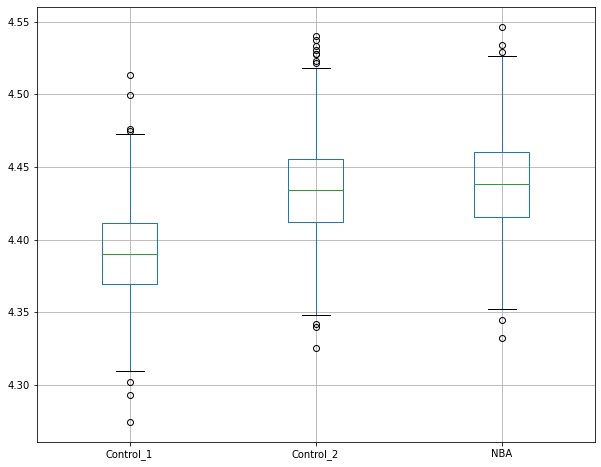

In [146]:
plt.figure(figsize=(10,8))
dist_samples.boxplot(column=['Control_1', 
                                       'Control_2',
                            'NBA'])
print(filtered)

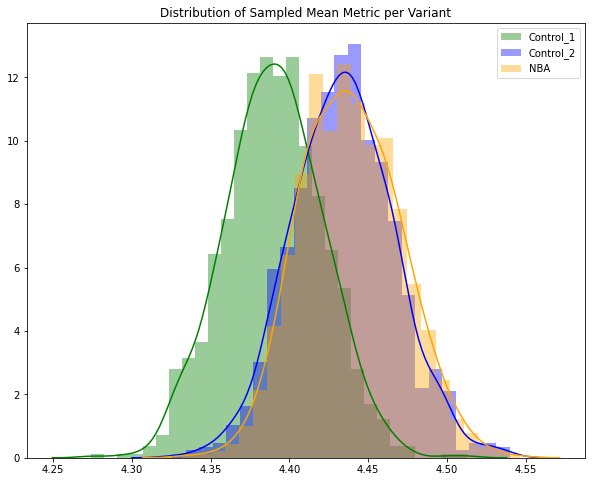

In [148]:
plt.figure(figsize=(10,8))
sb.distplot(dist_samples[['Control_1']], hist=True, color='green')
sb.distplot(dist_samples[['Control_2']], hist=True, color='blue')
sb.distplot(dist_samples[['NBA']], hist=True, color='orange')
plt.legend(labels=['Control_1','Control_2','NBA'])
plt.title("Distribution of Sampled Mean Metric per Variant")
plt.show()

## Statistical Comparisons

### Control group 1 vs NBA

In [204]:
## Create seperate frames for variants

Control_1 = dist_samples.Control_1
NBA = dist_samples.NBA


# Format data for BEST analysis

y1 = np.array(Control_1)
y2 = np.array(NBA)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['NBA']*len(NBA), ['Control_1']*len(Control_1)]))

In [205]:
# Set hyper-parameters for group means

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
# very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

In [206]:
# Set hyper-parameters for group standard-deviations

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
#very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

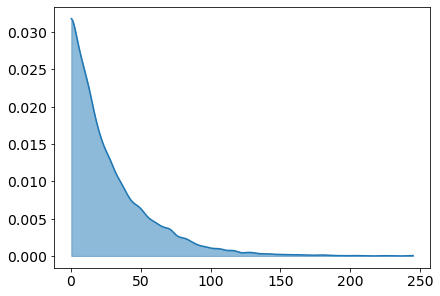

In [207]:
##  Set hyper-parameters for v (variance) 

# We follow Kruschke by making the prior for 𝜈 exponentially distributed with a mean of 30;
# this allocates high prior probability over the regions of the parameter that describe the 
# range from normal to heavy-tailed data under the Student-T distribution.

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [208]:
# Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, 
# we must transform the standard deviations before specifying our likelihoods.

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('Control_1', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('NBA', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [209]:
# Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of 
# interest in order to evaluate the effect of the intervention/experimental condition

with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [210]:
# Now, we can fit the model and evaluate its output 

with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


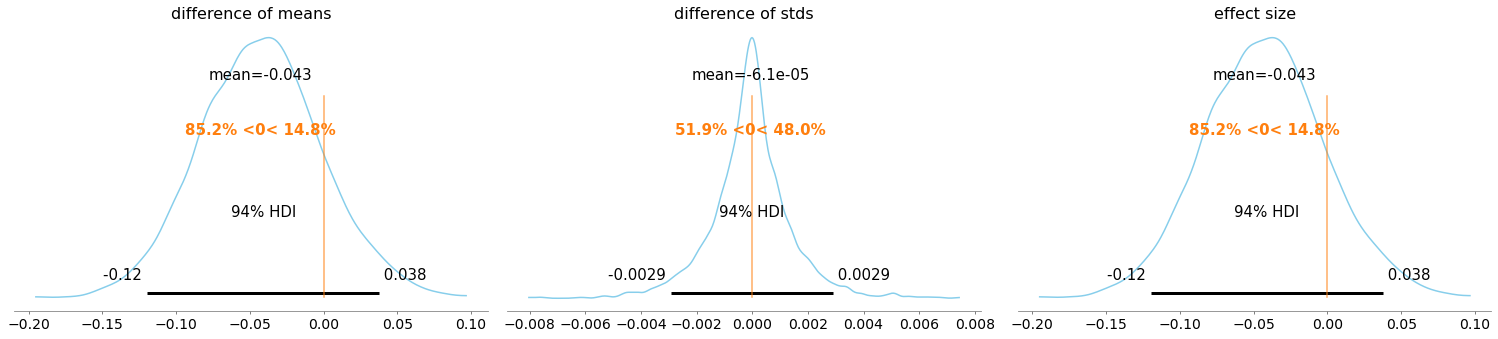

In [211]:
# Differences between groups and effect size

pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

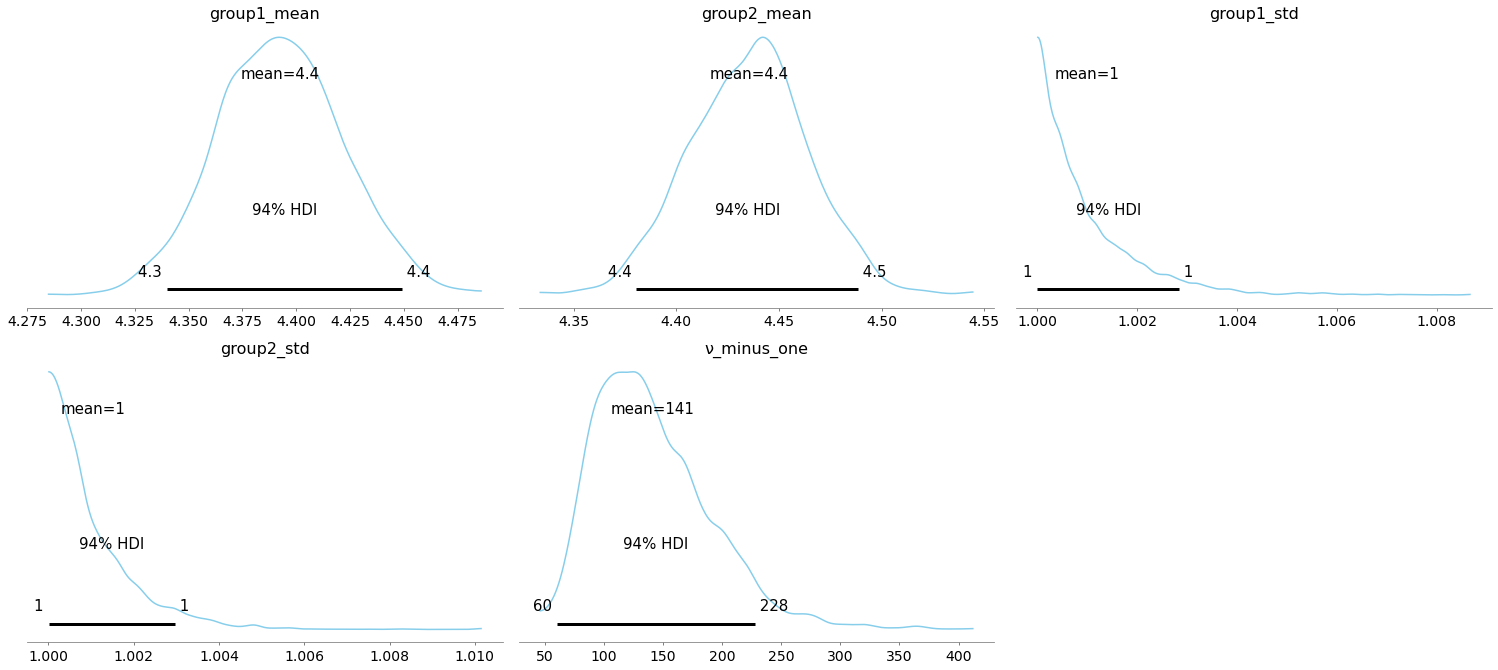

In [212]:
# We can plot the stochastic parameters of the model. PyMC’s plot_posterior function replicates the informative histograms 
## portrayed in Kruschke (2012). These summarize the posterior distributions of the parameters, and present a 95% credible interval 
## and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

### Control group 2 vs NBA

In [213]:
## Create seperate frames for variants

Control_2 = dist_samples.Control_2
NBA = dist_samples.NBA


# Format data for BEST analysis

y1 = np.array(Control_2)
y2 = np.array(NBA)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['NBA']*len(NBA), ['Control_2']*len(Control_2)]))

In [217]:
# Set hyper-parameters for group means

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
# very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

In [218]:
# Set hyper-parameters for group standard-deviations

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
#very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

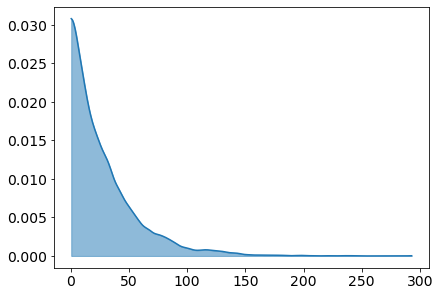

In [219]:
##  Set hyper-parameters for v (variance) 

# We follow Kruschke by making the prior for 𝜈 exponentially distributed with a mean of 30;
# this allocates high prior probability over the regions of the parameter that describe the 
# range from normal to heavy-tailed data under the Student-T distribution.

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [220]:
# Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, 
# we must transform the standard deviations before specifying our likelihoods.

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('NBA', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('Control_2', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [221]:
# Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of 
# interest in order to evaluate the effect of the intervention/experimental condition

with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [222]:
# Now, we can fit the model and evaluate its output 

with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


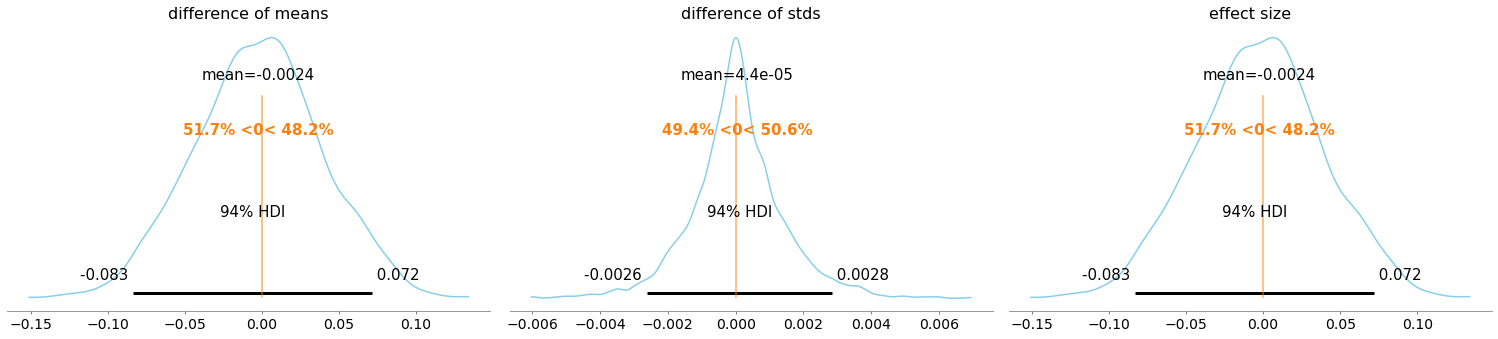

In [225]:
# Differences between groups and effect size

pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

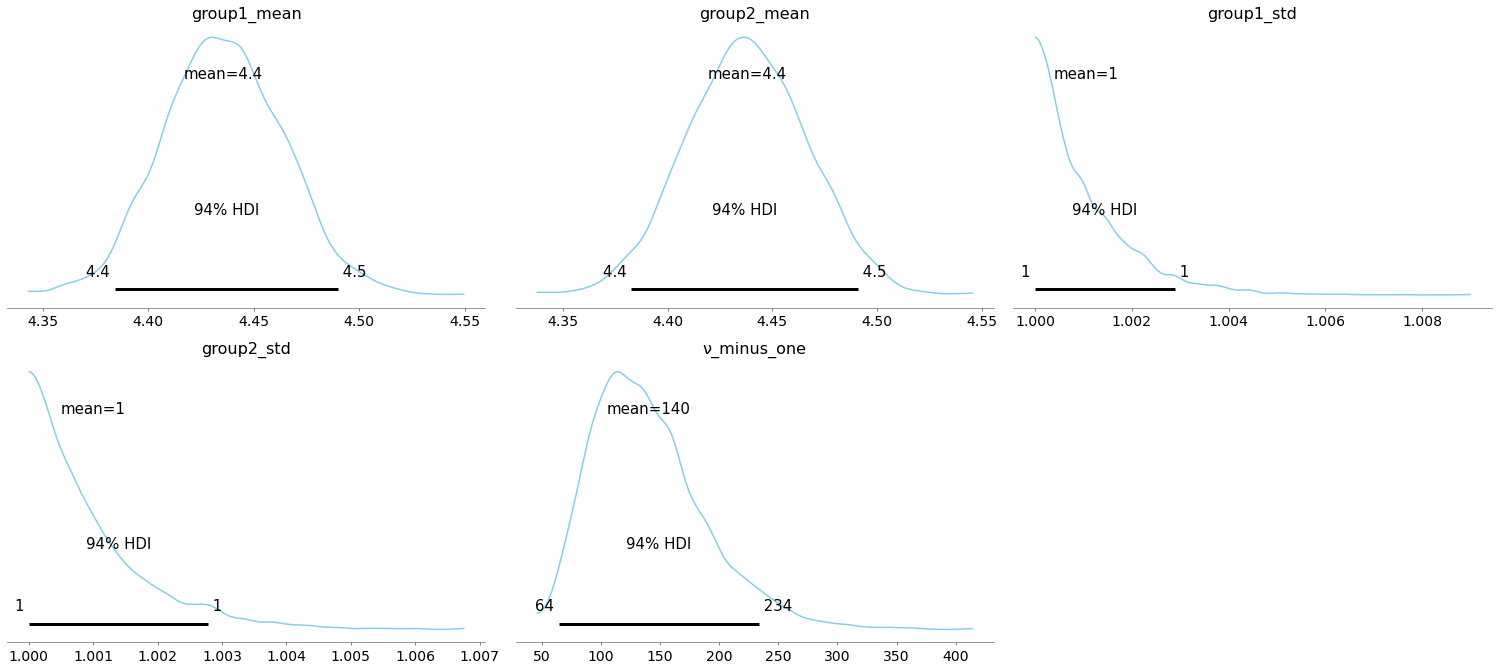

In [226]:
# We can plot the stochastic parameters of the model. PyMC’s plot_posterior function replicates the informative histograms 
## portrayed in Kruschke (2012). These summarize the posterior distributions of the parameters, and present a 95% credible interval 
## and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

### Control group 1 vs Control group 2

In [227]:
## Create seperate frames for variants

Control_1 = dist_samples.Control_1
Control_2 = dist_samples.Control_2


# Format data for BEST analysis

y1 = np.array(Control_1)
y2 = np.array(Control_2)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['Control_2']*len(Control_2), ['Control_1']*len(Control_1)]))

In [228]:
# Set hyper-parameters for group means

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
# very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

In [229]:
# Set hyper-parameters for group standard-deviations

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
#very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

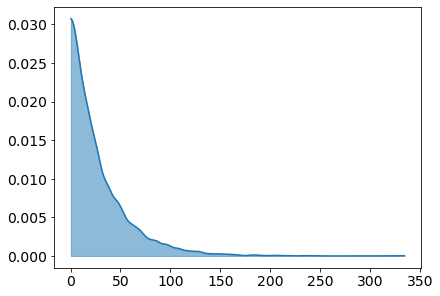

In [230]:
##  Set hyper-parameters for v (variance) 

# We follow Kruschke by making the prior for 𝜈 exponentially distributed with a mean of 30;
# this allocates high prior probability over the regions of the parameter that describe the 
# range from normal to heavy-tailed data under the Student-T distribution.

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [231]:
# Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, 
# we must transform the standard deviations before specifying our likelihoods.

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('Control_1', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('Control_2', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [232]:
# Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of 
# interest in order to evaluate the effect of the intervention/experimental condition

with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [233]:
# Now, we can fit the model and evaluate its output 

with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


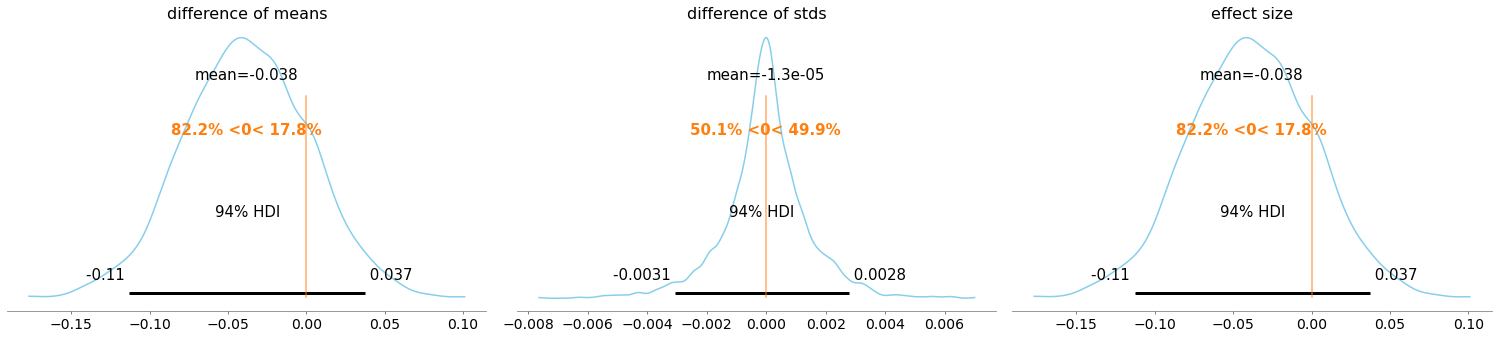

In [234]:
# Differences between groups and effect size

pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

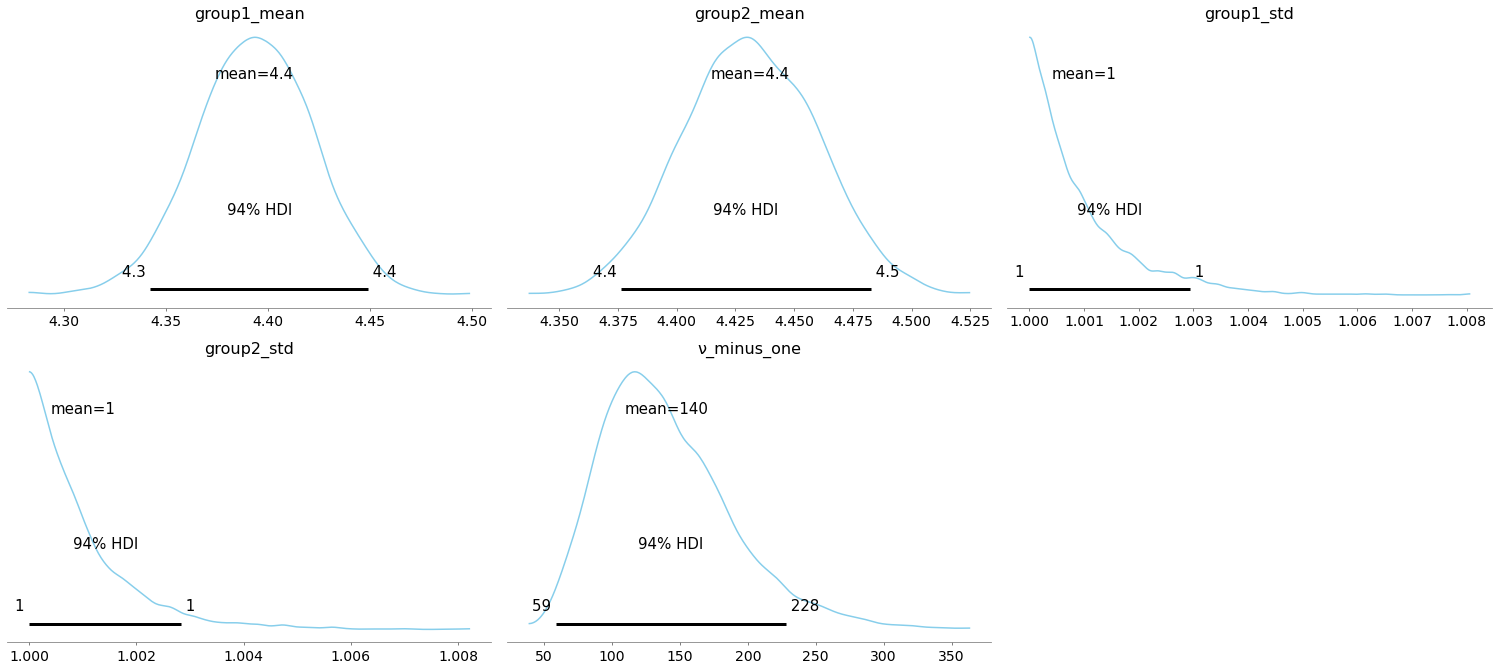

In [235]:
# We can plot the stochastic parameters of the model. PyMC’s plot_posterior function replicates the informative histograms 
## portrayed in Kruschke (2012). These summarize the posterior distributions of the parameters, and present a 95% credible interval 
## and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

# Click-through Rate

### Control group 2 vs NBA

In [245]:
from numba import jit
import numpy as np
from math import lgamma
from scipy.stats import beta

In [246]:
n_control = 164246

n_nba = 174904

In [247]:
e_control = 7883

e_nba = 10348

In [248]:
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [252]:
## Control ##

a_control = e_control + 1
b_control = n_control - (e_control + 1)
beta_control = beta(a_control, b_control)

## Variant ##

a_nba = e_nba + 1
b_nba = n_nba - (e_nba + 1)
beta_nba = beta(a_nba, b_nba)


## Calculate the conversion probabilities/rates

print("The conversion rate of the control is:",round(e_control/n_control,4)*100,"%")
print("The conversion rate of NBA variant is:",round(e_nba/n_nba,4)*100,"%")

## Calcuate the uplift

uplift = (beta_nba.mean() - beta_control.mean())/beta_control.mean()
print("The relative uplift/decrease between NBA and Control group is:",round(uplift*100,4),"%")

## Calculate the probability for test to be better than the control

print("The probability that NBA beat Control is:",round(prob*100,3),"%")

The conversion rate of the control is: 4.8 %
The conversion rate of NBA variant is: 5.92 %
The relative uplift/decrease between NBA and Control group is: 23.267 %
The probability that NBA beat Control is: 100.0 %


In [253]:
with pm.Model() as model:
    
    # Define priors (use the control pirior as the null hypothesis where no difference exists between variants)
    
    prior_control = pm.Beta('prior_control', alpha = e_control, beta = n_control - e_control)
    prior_nba = pm.Beta('prior_variant', alpha = e_nba, beta = n_nba - e_nba)

    # Define likelihood
    
    likelihood_control = pm.Binomial('like_control', n = 164246, p = prior_control, observed = e_control)
    likelihood_variant = pm.Binomial('like_variant', n = 174904, p = prior_nba, observed = e_nba)
    
    # Define metrics
    
    pm.Deterministic('absolute difference', prior_nba - prior_control)
    pm.Deterministic('relative difference', (prior_nba / prior_control) - 1)

    # Inference using MCMC
    trace = pm.sample(draws = 20000, step = pm.Metropolis(), start = pm.find_MAP(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [prior_variant]
>Metropolis: [prior_control]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


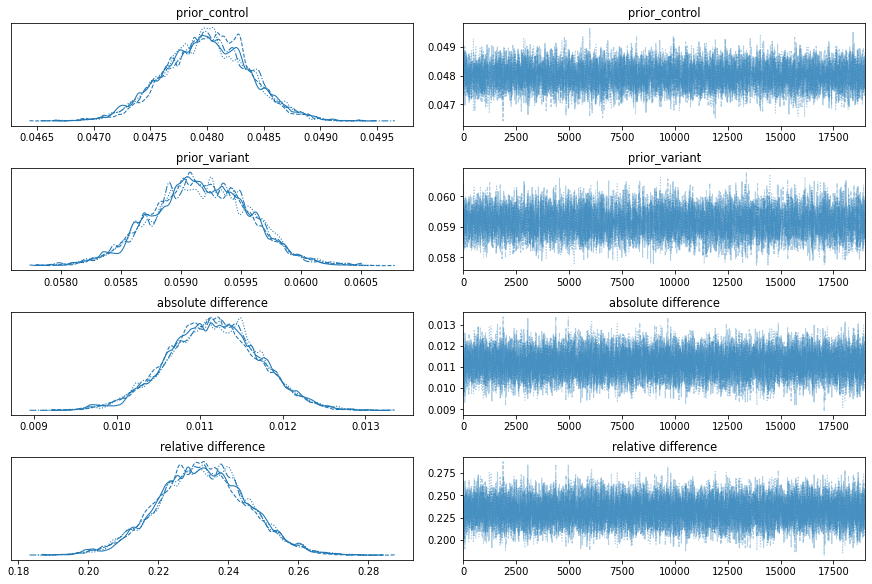

In [254]:
_ = pm.traceplot(trace[1000:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5cffaf820>,
      dtype=object)

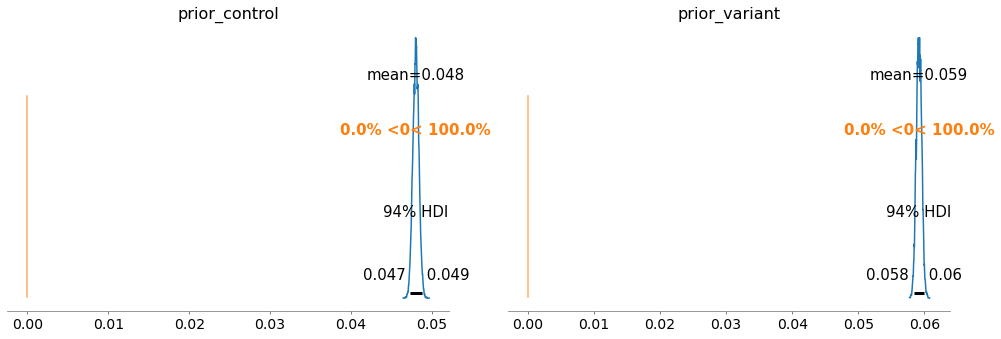

In [255]:
pm.plot_posterior(trace, var_names=['prior_control', 'prior_variant'], 
                      ref_val=0)

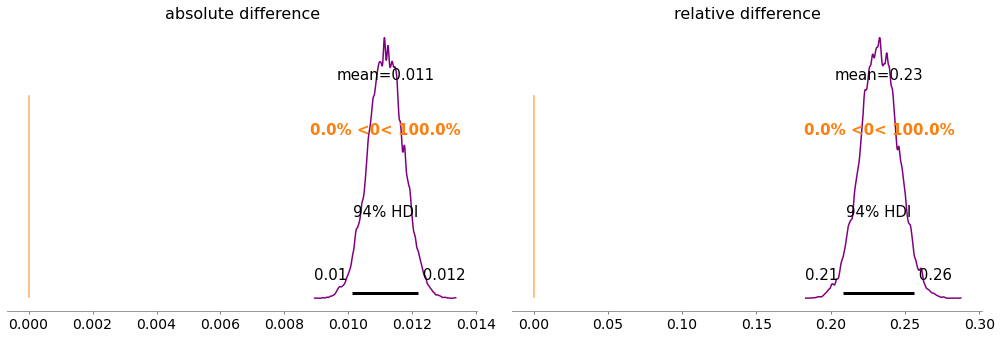

In [256]:
_ = pm.plot_posterior(trace[1000:], varnames=['absolute difference', 'relative difference'], 
                      ref_val=0, color='purple')